In [1]:
!pip install seaborn

     |████████████████████████████████| 285 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 27.2 MB 10.4 MB/s eta 0:00:01    |██                              | 1.8 MB 10.1 MB/s eta 0:00:03     |████████▉                       | 7.5 MB 10.1 MB/s eta 0:00:02     |███████████████████▋            | 16.7 MB 5.0 MB/s eta 0:00:03


In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

Nous avons décidé de créer une classe Scraper pour rassembler toutes les fonctions dont nous aurons besoin pour scraper le site web que nous avons choisi.

In [3]:
class Scraper:
    def __init__(self, url):
        self.chrome_options = webdriver.ChromeOptions()
        self.chrome_options.add_argument('--no-sandbox')
        self.chrome_options.add_argument('--window-size=1420,1080')
        self.chrome_options.add_argument('--headless')
        self.chrome_options.add_argument('--disable-gpu')
        self.chrome_options.add_argument('--disable-dev-shm-usage')  
        self.driver = webdriver.Chrome(options=self.chrome_options)
        self.url = url
    
    def access_website(self):
        self.driver.get(self.url)
        
    def click_on_by_text(self,text):
        self.driver.find_element_by_link_text(text).click()
   
    def click_on_by_xpath(self,xpath):
        self.driver.find_element_by_xpath(xpath).click()
    
    def accept_cookies(self):
        self.driver.find_element_by_xpath("//button[text()='Accept All']").click()
    
    def get_show(self, results, category):
        all_widgets = self.driver.find_elements_by_class_name("explore-results")
        first_line = all_widgets[0]
        all_first_line_elements = first_line.find_elements_by_class_name('col-inline')
        all_first_line_images = first_line.find_elements_by_css_selector('img.responsive-img')
        for i in range(len(all_first_line_elements)):
            try:
                show = all_first_line_elements[i].text.split('\n')
                details = show[1].split('•')
                votes_details = details[1].split('(')
                image = all_first_line_images[i].get_attribute('src')
                results.append({'Type': category, 'Nom': show[0], 'Pays': details[0], 'Note': votes_details[0],
                                'Nb_votes': votes_details[1].split(' ')[0], 'image': image})
            except:
                continue
        return results
    
    def get_all_shows(self, pages, category):
        results = []
        for i in range(pages):
            try:
                self.get_show(results, category)
                WebDriverWait(self.driver, 30).until(
                    EC.element_to_be_clickable((By.XPATH, "//a[text()='Suivant →']"))).click()
            except:
                continue
        return results
    
    def quitDriver(self):
        self.driver.quit()

In [4]:
chrome = Scraper('https://www.viki.com/?locale=fr')

In [5]:
chrome.access_website()

In [6]:
chrome.accept_cookies()

In [7]:
chrome.click_on_by_text('Explorer')

In [8]:
chrome.click_on_by_text('Tous les spectacles')

In [9]:
chrome.click_on_by_xpath("//span[text()='Tous les types']")

In [10]:
chrome.click_on_by_xpath("//div[text()='Télévision']")

In [11]:
series = chrome.get_all_shows(5,'Série')

In [13]:
chrome.click_on_by_xpath("//span[text()='Télévision']")

In [14]:
chrome.click_on_by_xpath("//div[text()='Films']")

In [15]:
movies = chrome.get_all_shows(3,'Film')

In [16]:
chrome.quitDriver()

In [17]:
shows = series + movies

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import ConnectionPatch

In [20]:
df_shows = pd.read_csv('viki_shows.csv')

In [21]:
df_shows.head()

,Type,Nom,Pays,Note,Nb_votes,image
0,Série,The Penthouse,Corée,9.2,26815,https://6.vikiplatform.com/image/220415a8e07d4...
1,Série,À L'ANTENNE Tu es mon héros,Chine Continentale,9.5,6343,https://6.vikiplatform.com/image/2fb5571e0da94...
2,Série,True Beauty,Corée,9.6,143241,https://6.vikiplatform.com/image/8533baa0008c4...
3,Série,À L'ANTENNE The Sweet Blood,Corée,9.0,2159,https://6.vikiplatform.com/image/4974bb047c974...
4,Série,The Penthouse 2 (Le Penthouse 2),Corée,9.5,15256,https://6.vikiplatform.com/image/164f623344524...


In [23]:
df_shows['on_air'] = df_shows['Nom'].str.contains("À L'ANTENNE")
dictionary = {True: "On air", False: "Finished"}
df_shows['on_air'] = df_shows['on_air'].map(dictionary)
df_shows['Nom'] = df_shows['Nom'].str.replace("À L'ANTENNE", '')

In [24]:
df_shows.sort_values('Nom',inplace=True)

In [25]:
df_shows.drop_duplicates(subset ="Nom",keep = False, inplace = True)

In [27]:
from pymongo import MongoClient

In [28]:
client = MongoClient("mongo")

In [29]:
db_viki = client.viki

In [30]:
collection_viki = db_viki['shows']

In [13]:
collection_viki.insert_many(viki_shows)

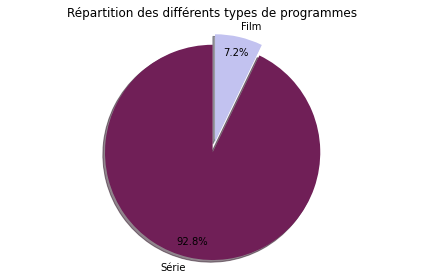

In [32]:
#type série/film
cur = collection_viki.aggregate([{"$group" : {"_id" : "$Type", "TypeShows" : {"$sum" : 1}}}])
res = pd.DataFrame(list(cur))
explode = (0.05, 0.05)
colors = ['#701f57', '#c2c2f0']

fig1,ax1 = plt.subplots()
type_shows = res['TypeShows']
labels = res['_id']
ax1.pie(type_shows, explode=explode, labels=labels, pctdistance=0.85, autopct='%1.1f%%', shadow=True, colors=colors,startangle=90)
ax1.axis('equal')
ax1.set_title('Répartition des différents types de programmes')
plt.tight_layout()
plt.show()

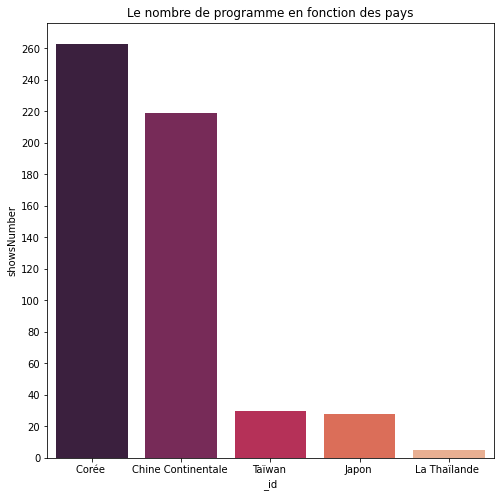

In [33]:
#pays
cur = collection_viki.aggregate([{"$group" : {"_id" : "$Pays", "showsNumber" : {"$sum" : 1}}},{'$sort':{'showsNumber':-1}}])
res = pd.DataFrame(list(cur))
plt.figure( figsize = (8,8) )
plt.title('Le nombre de programme en fonction des pays')
sns.barplot(x='_id',y='showsNumber',data=res,palette='rocket')
plt.yticks(np.arange(0, 270, 20))
plt.show()

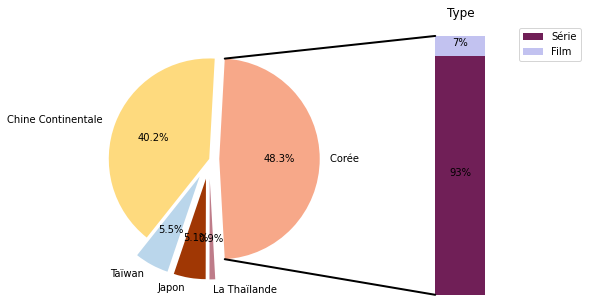

In [44]:
cur_total = collection_viki.aggregate([{"$group" : {"_id" : "$Pays", "showsNumber" : {"$sum" : 1}}},{'$sort':{'showsNumber':-1}}])
res_total = pd.DataFrame(list(cur_total))
cur_repart = collection_viki.aggregate([{"$group" : {"_id" : {"pays":"$Pays","type":"$Type"},"showsNumber" : {"$sum" : 1}}},{'$sort':{'showsNumber':-1}}])
res_repart = pd.DataFrame(list(cur_repart))
res_repart = pd.concat([res_repart.drop(['_id'], axis=1), res_repart['_id'].apply(pd.Series)], axis=1)
res_repart.sort_values('pays', inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

labels_total = res_total['_id']
sum_res = res_total.sum(axis=0,skipna=True)
ratios = res_total['showsNumber'] / sum_res['showsNumber']

explode_total = (0.1, 0, 0.2, 0.2, 0.2)
angle = -180 * ratios[0]
colors_total = ['#f7a889', '#feda7e', '#bad6eb', '#a03704', '#be7c89']
ax1.pie(ratios, autopct='%1.1f%%', startangle=angle, labels=labels_total, colors=colors_total,explode=explode_total, normalize=False)

xpos = 0
bottom = 0
ratios = [.93, .08]
width = .2
colors_repart = ['#701f57', '#c2c2f0']

for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=colors_repart[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    ax2.text(xpos, ypos, "%d%%" % (ax2.patches[j].get_height() * 100), ha='center')

ax2.set_title('Type')
ax2.legend(('Série', 'Film'))
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData, xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData, xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

plt.show()

Text(0.5, 1.0, 'Répartition des 5 meilleures séries')

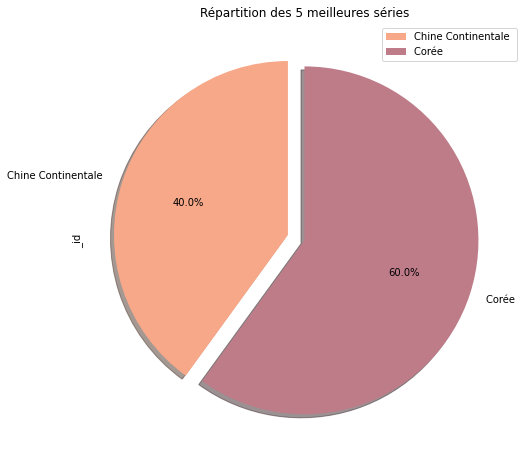

In [35]:
#5 mieux notés
cur = collection_viki.find({'Type':'Série'}).sort('Note',-1).limit(5)
df_res = pd.DataFrame(list(cur))
explode=[.1,0]
colors = ['#f7a889', '#be7c89']
df_res.pivot_table('_id',index='Pays',aggfunc='count').plot(kind='pie',subplots=True,colors = colors, explode=explode, autopct='%1.1f%%', shadow=True,figsize=(8,8),startangle=90)
plt.legend(loc='upper right')
plt.title('Répartition des 5 meilleures séries')